### Calibrate all floats that have oxygen data
*Create a local copy of Argo data, match it to World Ocean Atlas, and correct it to match climatology*

Use the `load_biofloat_cache.py` script to create a local cache file of all the data we want to work with:

```bash
load_biofloat_cache.py --age 365 -v >> age365.out 2>&1 &
```

This script takes several days to complete and needs to be monitored as it depends on Internet resources which occaisonally fail to respond. The `load_biofloat_cache.py` can be killed and restarted as necessary to deal with these interruptions. We save the logger output to a log file (`age365.out`) to facilitate analysis of the data load. When this script was executed in November of 2015 it produced an 8.4 GB file (`biofloat_fixed_cache_age365.hdf`) which we can load and see how much oxygen data the file contains.

In [1]:
from biofloat import ArgoData
ad = ArgoData(cache_file='biofloat_fixed_cache_age365.hdf')

In [2]:
ocdf = ad.get_cache_file_oxy_count_df()
print ocdf.groupby('wmo').sum().sum()
print 'Float having DOXY_ADJUSTED data:', ocdf.wmo.count()
acdf = ad.get_cache_file_all_wmo_list()
print 'Number of floats examined:', len(acdf)

num_measurements    10510832
num_profiles           41828
dtype: int64
Float having DOXY_ADJUSTED data: 296
Number of floats examined: 558


That's over 10 million measurements from 41,828 profiles from 296 floats. The `load_biofloat_cache.py` script examined 558 floats for valid oxygen data. All of the profile data are in this file and the data from any float can be explored as demonstrated in the Notebooks [explore_cached_biofloat_data.ipynb](explore_cached_biofloat_data.ipynb) and [explore_surface_oxygen_and_WOA.ipynb](explore_surface_oxygen_and_WOA.ipynb).

---

To compare these data against the World Ocean Atlas database we can execute the woa_calibration.py script:

```bash
woa_calibration.py --cache_file biofloat_fixed_cache_age365.hdf -v --results_file woa_lookup.hdf
```

This script takes a few hours to complete, but once it's done we have surface monthly data from Argo floats and corresponding WOA data to explore.

Let's load in the `woa_calibration.py` generated data into a single DataFrame.

In [3]:
import pandas as pd
df = pd.DataFrame()
with pd.HDFStore('woa_lookup.hdf') as s:
    for wmo in ocdf.wmo:
        df = df.append(s.get(('/WOA_WMO_{}').format(wmo)))
print df.head()
print df.describe()

                         o2sat   woa_o2sat      wmo       date      gain
wmo     year month                                                      
1901158 2011 2      360.619832  105.071640  1901158 2011-02-01  0.291364
             3      351.939087  104.036407  1901158 2011-03-01  0.295609
             4      342.336582  102.895668  1901158 2011-04-01  0.300569
             5      331.277857  101.628204  1901158 2011-05-01  0.306776
             6      318.694409   98.690773  1901158 2011-06-01  0.309672
              o2sat    woa_o2sat         gain
count  8.607000e+03  8626.000000  8572.000000
mean   3.175135e+23   100.308170          inf
std    2.945697e+25     4.282364          NaN
min   -4.914483e+02    74.906464  -483.202681
25%    8.967336e+01    98.281399     1.025628
50%    9.392668e+01   100.764709     1.068257
75%    9.782404e+01   102.891357     1.108588
max    2.732838e+27   116.850693          inf


There are obviously bad values of o2sat in this DataFrame, let's restrict data to a reasonably valid range.

In [4]:
qdf = df.query('(o2sat > 50 ) & (o2sat < 200)')
qdf.describe()

,o2sat,woa_o2sat,gain
count,8128.000000,8093.000000,8093.000000
mean,94.824702,100.337903,1.069585
std,11.568258,4.258545,0.109206
min,50.240882,74.906464,0.502262
25%,90.176534,98.325417,1.032756
50%,94.014938,100.775322,1.070351
75%,97.672916,102.912994,1.108892
max,199.698198,116.850693,2.104910


Plot the distribution of gains &mdash; comparible to Figure 4 in [Takeshita _et al._ (2013)](http://onlinelibrary.wiley.com/doi/10.1002/jgrc.20399/abstract).

Populating the interactive namespace from numpy and matplotlib


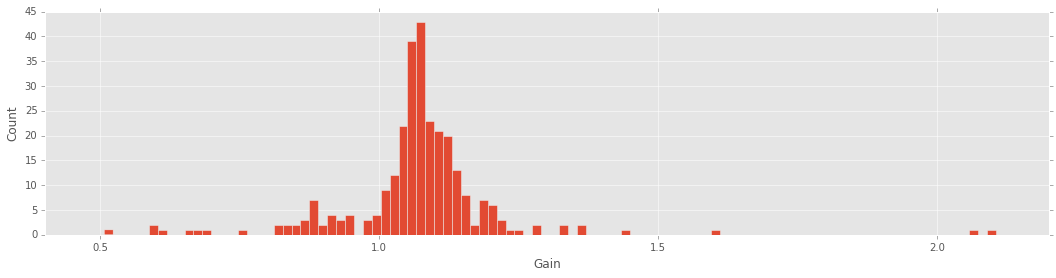

In [5]:
%pylab inline
import pylab as plt
plt.rcParams['figure.figsize'] = (18.0, 4.0)
plt.style.use('ggplot')
ax = qdf.groupby('wmo').mean().gain.hist(bins=100)
ax.set_xlabel('Gain')
ax.set_ylabel('Count')

Plot time series of gain for all the floats and fit an ordinary least squares regression to detect any drift in time of the gain for all the floats.

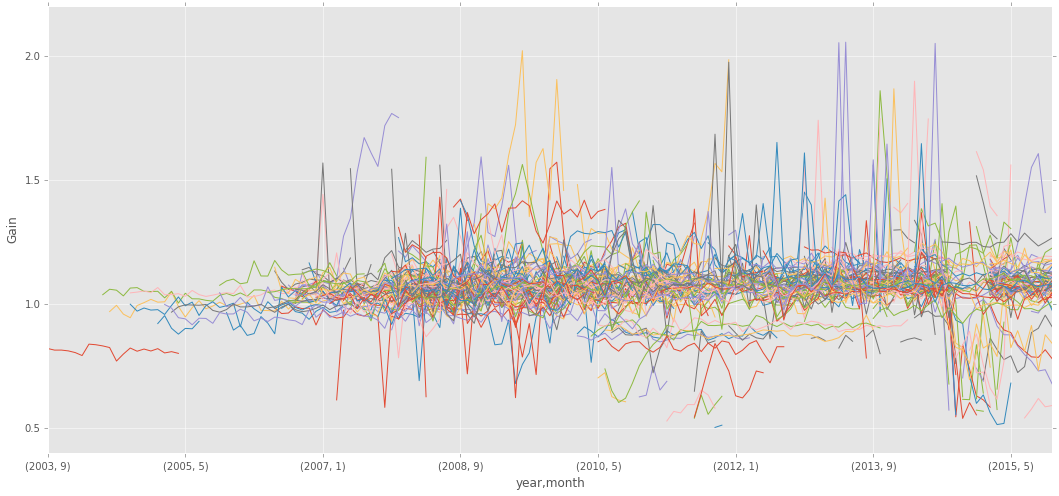

In [6]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
ax = qdf.unstack(level='wmo').gain.plot()
ax.set_ylabel('Gain')
ax.legend_.remove()

Make a list of all the floats in `qdf` and assign a color to each.

In [7]:
wmo_list = qdf.index.get_level_values('wmo').unique()
colors = cm.spectral(np.linspace(0, 1, len(wmo_list)))
print 'Number of floats with reasonable oxygen saturation values:', len(wmo_list)

Number of floats with reasonable oxygen saturation values: 285


Make scatter plot of float oxygen saturation vs. World Ocean Atlas oxygen saturation.

/home/mccann/VirtualEnvs/biofloat/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


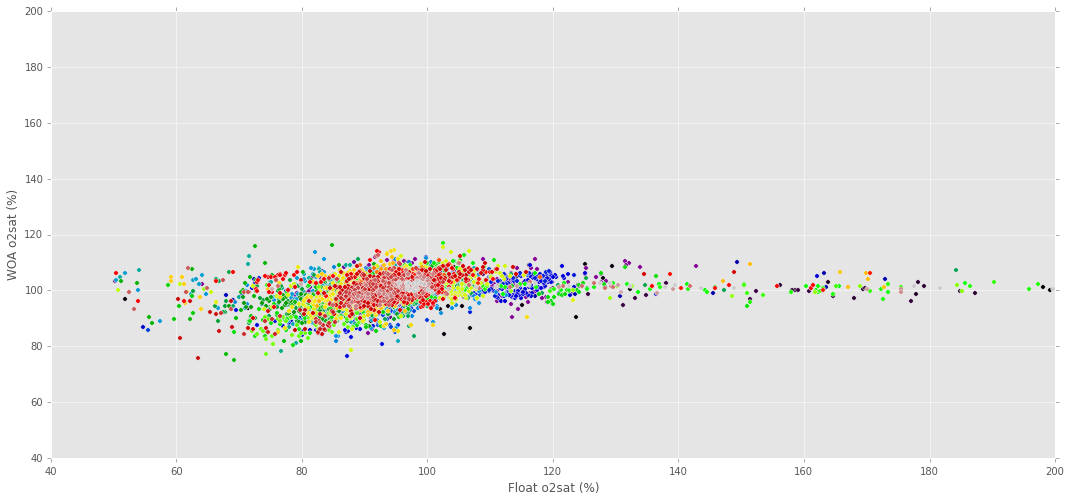

In [8]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
fig, ax = plt.subplots(1, 1)
for wmo, c in zip(wmo_list, colors):
    ax.scatter(qdf.xs(wmo, level='wmo')['o2sat'], qdf.xs(wmo, level='wmo')['woa_o2sat'], c=c)
ax.set_xlim([40, 200])
ax.set_ylim([40, 200])
ax.set_xlabel('Float o2sat (%)')
ax.set_ylabel('WOA o2sat (%)')

This first look at WOA oxygen calibration for all the Argo floats reveals that there are some issues with the data that warrant further exploration.